## Deep Research Experiment with `LangGraph`

This notebook aims to test multi-round research with back-and-forth between an OpenAI LLM and Perplexity. Orchestrated with `LangGraph`.



In [101]:
import os

from dotenv import load_dotenv
load_dotenv()

from IPython.display import display, Markdown, Image
from langchain_core.messages import BaseMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.constants import Send
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import add_messages
import operator

from pydantic import BaseModel, Field
from typing import Annotated, Sequence, TypedDict, List, Dict

### Prompts

In [109]:
system_message_content = """You are a helpful assistant that can help with research."""
system_message = SystemMessage(content=system_message_content)

### research question writer

user_message_template = """
A user requires help with their research question. They have provided a topic they are interested in and the reason for their interest. Additionally, they have provided some background on themselves to help you understand their perspective.

<topic>
{topic}
</topic>

<reason>
{reason}
</reason>

<background>
{background}
</background>


Your task is to write research questions that can be submitted to Perplexity or Google Scholar for further research. Return a list of research questions.
"""

### answer writer prompt

answer_writer_template = """
You are assisting a user with their research. The topic is:

<topic>
{topic}
</topic>

The question you need to answer is:
<question>
{question}
</question>

Provide a detailed answer to the question.
"""

### further research validator

further_research_validator_template = """
You are assisting a user with their research. The user has provided a research topic, for which questions have been already generated and answered. You will be provided with this list of questions and answers. Your task is to decide if, given the user's background and reason for interest, the answers are sufficient to carry out the research.

<topic>
{topic}
</topic>

<reason>
{reason}
</reason>

<background>
{background}
</background>

<questions and answers>
{questions_with_answers}
</questions and answers>

Return with the decision if further questions are needed, and if so, generate the next round of questions.
"""


### Structured Outputs

In [110]:
class ResearchQuestion(BaseModel):
    question: str = Field(description="A research question that can be submitted to Perplexity or Google Scholar for further research.")

class ResearchQuestions(BaseModel):
    questions: List[ResearchQuestion] = Field(description="A list of research questions that can be submitted to Perplexity or Google Scholar for further research.")

class FurtherResearchValidator(BaseModel):
    decision: bool = Field(description="A decision if further questions are needed (True) or not (False).")
    questions: List[ResearchQuestion] = Field(description="A list of research questions that can be submitted to Perplexity or Google Scholar for further research.")


### LLMs

In [125]:
question_writer_model = "gpt-4o-2024-11-20"
further_research_validator_model = "gpt-4o-2024-11-20"

question_writer_llm = ChatOpenAI(
    model=question_writer_model, 
    temperature=0.0
    )
question_writer_llm = question_writer_llm.with_structured_output(ResearchQuestions, method="json_schema", include_raw=True)

answer_writer_model = "llama-3.1-sonar-large-128k-online"
answer_writer_llm = ChatOpenAI(
    model=answer_writer_model, 
    temperature=0.0, 
    base_url="https://api.perplexity.ai", 
    api_key=os.getenv('PPLX_API_KEY')
    )

further_research_validator_llm = ChatOpenAI(
    model=further_research_validator_model, 
    temperature=0.0
    )
further_research_validator_llm = further_research_validator_llm.with_structured_output(FurtherResearchValidator, method="json_schema", include_raw=True)

Test question writer

In [111]:
topic = "The impact of AI on the job market"
reason = "I am interested in the impact of AI on the job market because I am a software engineer and I want to understand how AI is changing the job market."
background = "I am a software engineer and I have been working in the tech industry for 10 years."

user_message = user_message_template.format(topic=topic, reason=reason, background=background)

test_response = question_writer_llm.invoke([system_message] + [user_message])

In [114]:
test_response['parsed'].questions

[ResearchQuestion(question='What are the current trends in the adoption of AI technologies in the job market?'),
 ResearchQuestion(question='How is AI impacting the demand for software engineering roles in the tech industry?'),
 ResearchQuestion(question='What are the potential long-term effects of AI on employment across various industries?'),
 ResearchQuestion(question='How can software engineers adapt their skills to remain competitive in an AI-driven job market?'),
 ResearchQuestion(question='What are the ethical considerations of AI replacing human jobs in the workforce?')]

Test answer writer

In [119]:
answer_writer_prompt = answer_writer_template.format(topic=topic, question=test_response['parsed'].questions[0].question)
test_answer = answer_writer_llm.invoke([system_message] + [answer_writer_prompt])

In [120]:
print(test_answer.content[:750])

The adoption of AI technologies in the job market is undergoing significant transformations, driven by several key trends and forecasts. Here are some of the current and anticipated developments:

## Rapid Growth in AI-Related Jobs

AI is creating a substantial number of new job opportunities across various sectors. According to the World Economic Forum’s Future of Jobs Report 2025, AI and data processing alone are expected to create 11 million new roles by 2030, although they will also replace 9 million jobs[1].

Machine Learning Engineers, AI and machine learning specialists, and big data specialists are among the fastest-growing job titles. These roles are in high demand as companies integrate AI technologies to drive digital transformat


Test further research validator

In [126]:
further_research_validator_prompt = further_research_validator_template.format(
    topic=topic, 
    reason=reason, 
    background=background, 
    questions_with_answers=test_response['raw'].content
    )
test_further_research_validator = further_research_validator_llm.invoke([system_message] + [further_research_validator_prompt])

In [129]:
test_further_research_validator['parsed'].decision

True

In [130]:
test_further_research_validator['parsed'].questions

[ResearchQuestion(question='What specific AI technologies are most influential in shaping the job market currently?'),
 ResearchQuestion(question='Are there any case studies or examples of industries where AI has significantly altered the job landscape?'),
 ResearchQuestion(question='What are the educational or training resources available for software engineers to learn AI-related skills?'),
 ResearchQuestion(question='How do different regions or countries vary in their adoption of AI and its impact on their job markets?'),
 ResearchQuestion(question='What are the predictions for the job market in the next 5-10 years considering the advancements in AI?')]

### Build the graph

In [157]:
class AgentState(TypedDict):

    topic: str
    reason: str
    background: str

    messages: Annotated[Sequence[BaseMessage], add_messages]

    questions: List[str]
    question: str
    questions_with_answers: Annotated[List[Dict[str, str]], operator.add]

    further_research_rounds: int = 3
    further_research_needed: bool = False


In [158]:
def write_questions(state: AgentState) -> AgentState:

    user_message = user_message_template.format(
        topic=state['topic'], 
        reason=state['reason'], 
        background=state['background']
        )
    
    response = question_writer_llm.invoke([system_message] + [user_message])

    response_parsed = response["parsed"]
    response_raw = response["raw"]
    response_raw.name = 'Question Writer'
    
    questions = [question.question for question in response_parsed.questions]
    
    return {
        'questions': questions,
        'messages': [system_message] + [user_message] + [response_raw]
        }

def answer_question(state: AgentState) -> AgentState:

    print(f'Answering question: {state["question"]}')

    user_message = answer_writer_template.format(
        topic=state['topic'], 
        question=state['question']
        )
    
    response = answer_writer_llm.invoke([system_message] + [user_message])
    response.name = 'Answer Writer'

    return {
        'messages': [response],
        'questions_with_answers': [{'question': state['question'], 'answer': response.content}]
        }

def send_questions_to_answer_writer(state: AgentState) -> AgentState:

    return [Send("answer_question", {"question": q, "topic": state['topic']}) for q in state['questions']]

def validate_further_research(state: AgentState) -> AgentState:

    rounds_remaining = state['further_research_rounds']

    if rounds_remaining == 0:

        print('No further research rounds left.')

        return {
            'further_research_needed': False,
        }

    user_message = further_research_validator_template.format(
        topic=state['topic'], 
        reason=state['reason'], 
        background=state['background'], 
        questions_with_answers=state['questions_with_answers']
        )
    
    response = further_research_validator_llm.invoke([system_message] + [user_message])
    response_raw = response['raw']
    response_raw.name = 'Further Research Validator'

    if response['parsed'].decision:

        print(f'Further research needed. {rounds_remaining} rounds remaining max.')
        print(f'New questions: {response["parsed"].questions}')
    
        return {
            'further_research_rounds': rounds_remaining - 1,
            'further_research_needed': True,
            'questions': response['parsed'].questions, # overwrite questions with new questions
            'messages': [response_raw]
            }
    
    else:

        print('No further research needed.')

        return {
            'further_research_needed': False,
            'messages': [response_raw]
            }
    
def route_from_validation(state: AgentState):
    if state['further_research_needed']:
        return "go_deeper"
    else:
        return "end"

In [159]:
workflow = StateGraph(AgentState)

workflow.add_node("write_questions", write_questions)
workflow.add_node("answer_question", answer_question)
workflow.add_node("validate_further_research", validate_further_research)

workflow.add_edge(START, "write_questions")
workflow.add_conditional_edges("write_questions", send_questions_to_answer_writer, ["answer_question"])
workflow.add_edge("answer_question", "validate_further_research")

workflow.add_conditional_edges("validate_further_research", route_from_validation, {"end": END, "go_deeper": "answer_question"})

app = workflow.compile()

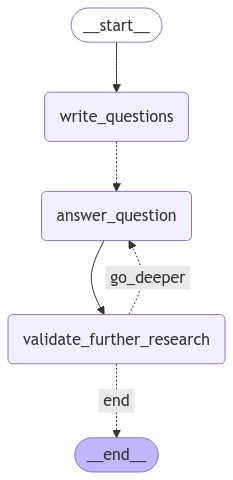

In [160]:
display(Image(app.get_graph().draw_mermaid_png()))

### Testing scenarios

In [167]:
scenarios = [
    {
        "topic": "The GOAT of the NFL",
        "reason": "I want to know who is the GOAT of the NFL.",
        "background": "I am a football fan and I have been watching the NFL for 20 years.",
        "further_research_rounds": 3,
        "further_research_needed": True
    },
    {
        "topic": "How to cook the perfect steak",
        "reason": "I want to know how to cook the perfect steak.",
        "background": "I am a foodie and I love to cook.",
        "further_research_rounds": 3,
        "further_research_needed": True
    },
    {
        "topic": "The best way to learn a new language",
        "reason": "I want to know the best way to learn a new language.",
        "background": "I am a language learner and I want to know the best way to learn a new language.",
        "further_research_rounds": 3,
        "further_research_needed": True
    }
]


In [168]:
scenarios_results = []

for scenario in scenarios:

    print(f'Running scenario: {scenario["topic"]}')

    test = app.invoke(scenario)
    scenarios_results.append(test)
    
    print('*' * 30)

Running scenario: The GOAT of the NFL
Answering question: Who is considered the greatest NFL player of all time (GOAT) and why?
Answering question: What criteria are used to determine the GOAT in the NFL?
Answering question: How do player statistics, championships, and individual awards contribute to the GOAT debate in the NFL?
Answering question: What are the arguments for and against Tom Brady being the GOAT of the NFL?
Answering question: How do different positions in football affect the evaluation of a player's greatness in the NFL?
No further research needed.
******************************
Running scenario: How to cook the perfect steak
Answering question: What are the best techniques for cooking a steak to achieve the perfect doneness?Answering question: What are the differences in flavor and texture between grilling, pan-searing, and sous-vide methods for cooking steak?
Answering question: How does the choice of steak cut affect the cooking method and final result?

Answering qu

In [169]:
scenarios_results[0]

{'topic': 'The GOAT of the NFL',
 'reason': 'I want to know who is the GOAT of the NFL.',
 'background': 'I am a football fan and I have been watching the NFL for 20 years.',
 'messages': [SystemMessage(content='You are a helpful assistant that can help with research.', id='821c4c80-04c5-465d-87bf-d659dd6df6d4'),
  HumanMessage(content='\nA user requires help with their research question. They have provided a topic they are interested in and the reason for their interest. Additionally, they have provided some background on themselves to help you understand their perspective.\n\n<topic>\nThe GOAT of the NFL\n</topic>\n\n<reason>\nI want to know who is the GOAT of the NFL.\n</reason>\n\n<background>\nI am a football fan and I have been watching the NFL for 20 years.\n</background>\n\n\nYour task is to write research questions that can be submitted to Perplexity or Google Scholar for further research. Return a list of research questions.\n', id='156b6b48-e6b6-4e16-9f3a-28a665d26615'),
  A